In [7]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import pathlib
import pickle #to save files
from itertools import product
from scipy.stats import skew, kurtosis

%matplotlib inline
pd.__version__

'0.18.1'

In [2]:
# Set path to folder containing Subject ID numbers
# path = '/Volumes/RT&O/CIS-PD Study/Subjects/' #Mac
path = '../Data/' #dictionaries data Mac - (local)
#---------------------------------------------------------------------------------------------------------

In [67]:
def plot_data(acts, activity, trial, sensor, data, start=0, end=100000):
#---------------------------------------------------------------------------------------------------------
# Plots requested data
# 
# Inputs: acts - activity dataframe containing all sensor data from one subject
#         activity - desired activity to plot
#         trial - desired trial number to plot
#         sensor - desired sensor (serial number or name of location) to analyze
#         data - desired type of data to analyze (accel, gyro, EMG/ECG)
#         start - starting index, default starts at first point
#         end - ending index, default is 500th data point
#---------------------------------------------------------------------------------------------------------
    rawdata = pd.DataFrame(acts[activity][trial]).loc[data, sensor]#[start:end]
    #reindex time (relative to start)
    idx = rawdata.index
    idx = idx-idx[0]
    rawdata.index = idx
    rawdata.plot(figsize=(5,3))

In [10]:
#list subjects in db
d = os.listdir(path)
f = [filename for filename in d if filename.startswith('1')] #need to update to skip existing files in /data
print(f)

['1004dict.pkl', '1016dict.pkl', '1018dict.pkl', '1019dict.pkl', '1020dict.pkl', '1044dict.pkl']


## Choose subject, task, visit and sensor location

In [117]:
subj = 1018 #choose subj to visualize

In [184]:
#choose task, trials(visits) and sensor location
task = 'Motor #8: Typing on a Computer'
task_scores = 'Typing on a computer keyboard' #the task name in the scores file
loc = 'dorsal_hand_left'
# task = 'Motor #3: Walking while Counting'
# task_scores = 'Walking while counting'
# loc = 'dorsal_hand_right'

trials = [0,1,5,6]

In [229]:
#load Pickle file dict and scores
subj_filename = str(subj) + 'dict.pkl'
f = open('../Data/'+subj_filename,'rb')
act_dict = pickle.load(f)
f.close()
#load subject scores
pathscores = '../Scores/'
mot_scores = pd.read_excel(os.path.join(pathscores, 'MotorTasks.xls'))
#remove (Qxx) from each column for readability
cols= mot_scores.columns
cols = cols[4:]
cols = cols.tolist()
colsnew = [x.split('(')[0] for x in cols]
colsnew = [x[0:-1] for x in colsnew]
c = dict(zip(cols,colsnew))
mot_scores = mot_scores.rename(index=str, columns=c)

In [231]:
mot_scores.head(3)

,Site,Subject,Visit,CRF#,Data Collected,Date of assessment,What is the participants state,On which hand is the subject wearing the Apple watch,Was the device shaken 5 times up and down prior to beginning the assessment,Patients Apple watch clock time when the stop watch is turned on,...,Folding towels tremor left upper limb rating,Folding towels tremor right upper limb rating,Was sitting assessed,Sitting start time,Sitting end time,Sitting dyskinesia left upper limb rating,Sitting dyskinesia right upper limb rating,Sitting tremor left upper limb rating,Sitting tremor upper right limb rating,General Comments
0,"Northwestern Memorial Hospital, Chicago, IL",1004,2 Weeks: Time 0,438,Yes,2017-07-07,Off,Right,Yes,08:38:40,...,1,1,Yes,00:15:20,00:15:50,0,0,0,0,NaN
1,"Northwestern Memorial Hospital, Chicago, IL",1004,2 Weeks: Time 30,447,Yes,2017-07-07,Off,Right,Yes,09:22:59,...,0,0,Yes,00:11:53,00:12:23,0,0,0,0,NaN
2,"Northwestern Memorial Hospital, Chicago, IL",1004,2 Weeks: Time 60,449,Yes,2017-07-07,On,Right,Yes,10:03:50,...,0,0,Yes,00:10:10,00:10:40,0,1,0,0,NaN


In [177]:
sorted(list(act_dict.keys()))

['Heart Rate Variability',
 'MDS-UPDRS #10: Kinetic Hand Tremor',
 'MDS-UPDRS #11: Rest Tremor',
 'MDS-UPDRS #1: Finger Tapping',
 'MDS-UPDRS #2: Hand Movements',
 'MDS-UPDRS #3: Pronation-Supination',
 'MDS-UPDRS #4: Toe Tapping',
 'MDS-UPDRS #5: Leg Agility',
 'MDS-UPDRS #6: Arising from Chair',
 'MDS-UPDRS #7: Gait',
 'MDS-UPDRS #8: Postural Stability',
 'MDS-UPDRS #9: Postural Hand Tremor',
 'Motor #10: Drinking Water',
 'Motor #11: Organizing Folder',
 'Motor #12: Folding Towels',
 'Motor #13: Sitting',
 'Motor #1: Standing',
 'Motor #2: Walking',
 'Motor #3: Walking while Counting',
 'Motor #4: Finger to Nose',
 'Motor #5: Alternating Hand Movements',
 'Motor #6: Sit to Stand',
 'Motor #7: Drawing on Paper',
 'Motor #8: Typing on a Computer',
 'Motor #9: Nuts and Bolts']

In [232]:
#extract scores for corresponding task 
subj_score = mot_scores.loc[mot_scores['Subject']==subj,['Subject','Visit',
                            task_scores+ ' ' + 'bradykinesia right upper limb rating',
                            task_scores+ ' ' + 'tremor right upper limb rating',
                            task_scores+ ' ' + 'bradykinesia left upper limb rating',
                            task_scores+ ' ' + 'tremor left upper limb rating',
                            task_scores+ ' ' + 'overall score']]
subj_score = subj_score.rename(index=str,
                               columns={subj_score.columns[2]:'Bradykinesia right',subj_score.columns[3]:'Tremor right', 
                                       subj_score.columns[4]:'Bradykinesia left',subj_score.columns[5]:'Tremor left',
                                       subj_score.columns[6]:'overall'})
subj_score.index = range(len(subj_score))
subj_score

,Subject,Visit,Bradykinesia right,Tremor right,Bradykinesia left,Tremor left,overall
0,1018,2 Weeks: Time 0,0,0,2,0,2.0
1,1018,2 Weeks: Time 30,1,0,2,0,2.0
2,1018,2 Weeks: Time 60,1,0,2,0,2.0
3,1018,2 Weeks: Time 90,1,0,2,0,2.0
4,1018,2 Weeks: Time 120,1,0,2,0,2.0
5,1018,2 Weeks: Time 150,1,0,2,0,2.0
6,1018,1 Month,0,0,1,0,1.0


## Histogram of scores

In [233]:
S = mot_scores[[            task_scores+ ' ' + 'bradykinesia right upper limb rating',
                            task_scores+ ' ' + 'tremor right upper limb rating',
                            task_scores+ ' ' + 'bradykinesia left upper limb rating',
                            task_scores+ ' ' + 'tremor left upper limb rating',
                            task_scores+ ' ' + 'overall score']]

S = S.rename(index=str,columns={S.columns[0]:'Bradykinesia right',S.columns[1]:'Tremor right', 
                                       S.columns[2]:'Bradykinesia left',S.columns[3]:'Tremor left',
                                       S.columns[4]:'overall'})
S.head()

,Bradykinesia right,Tremor right,Bradykinesia left,Tremor left,overall
0,2,1,2,1,2.0
1,0,0,0,0,0.0
2,0,0,0,0,0.0
3,0,0,0,0,0.0
4,0,0,0,0,0.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x150e57ac8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1469eca20>]], dtype=object)

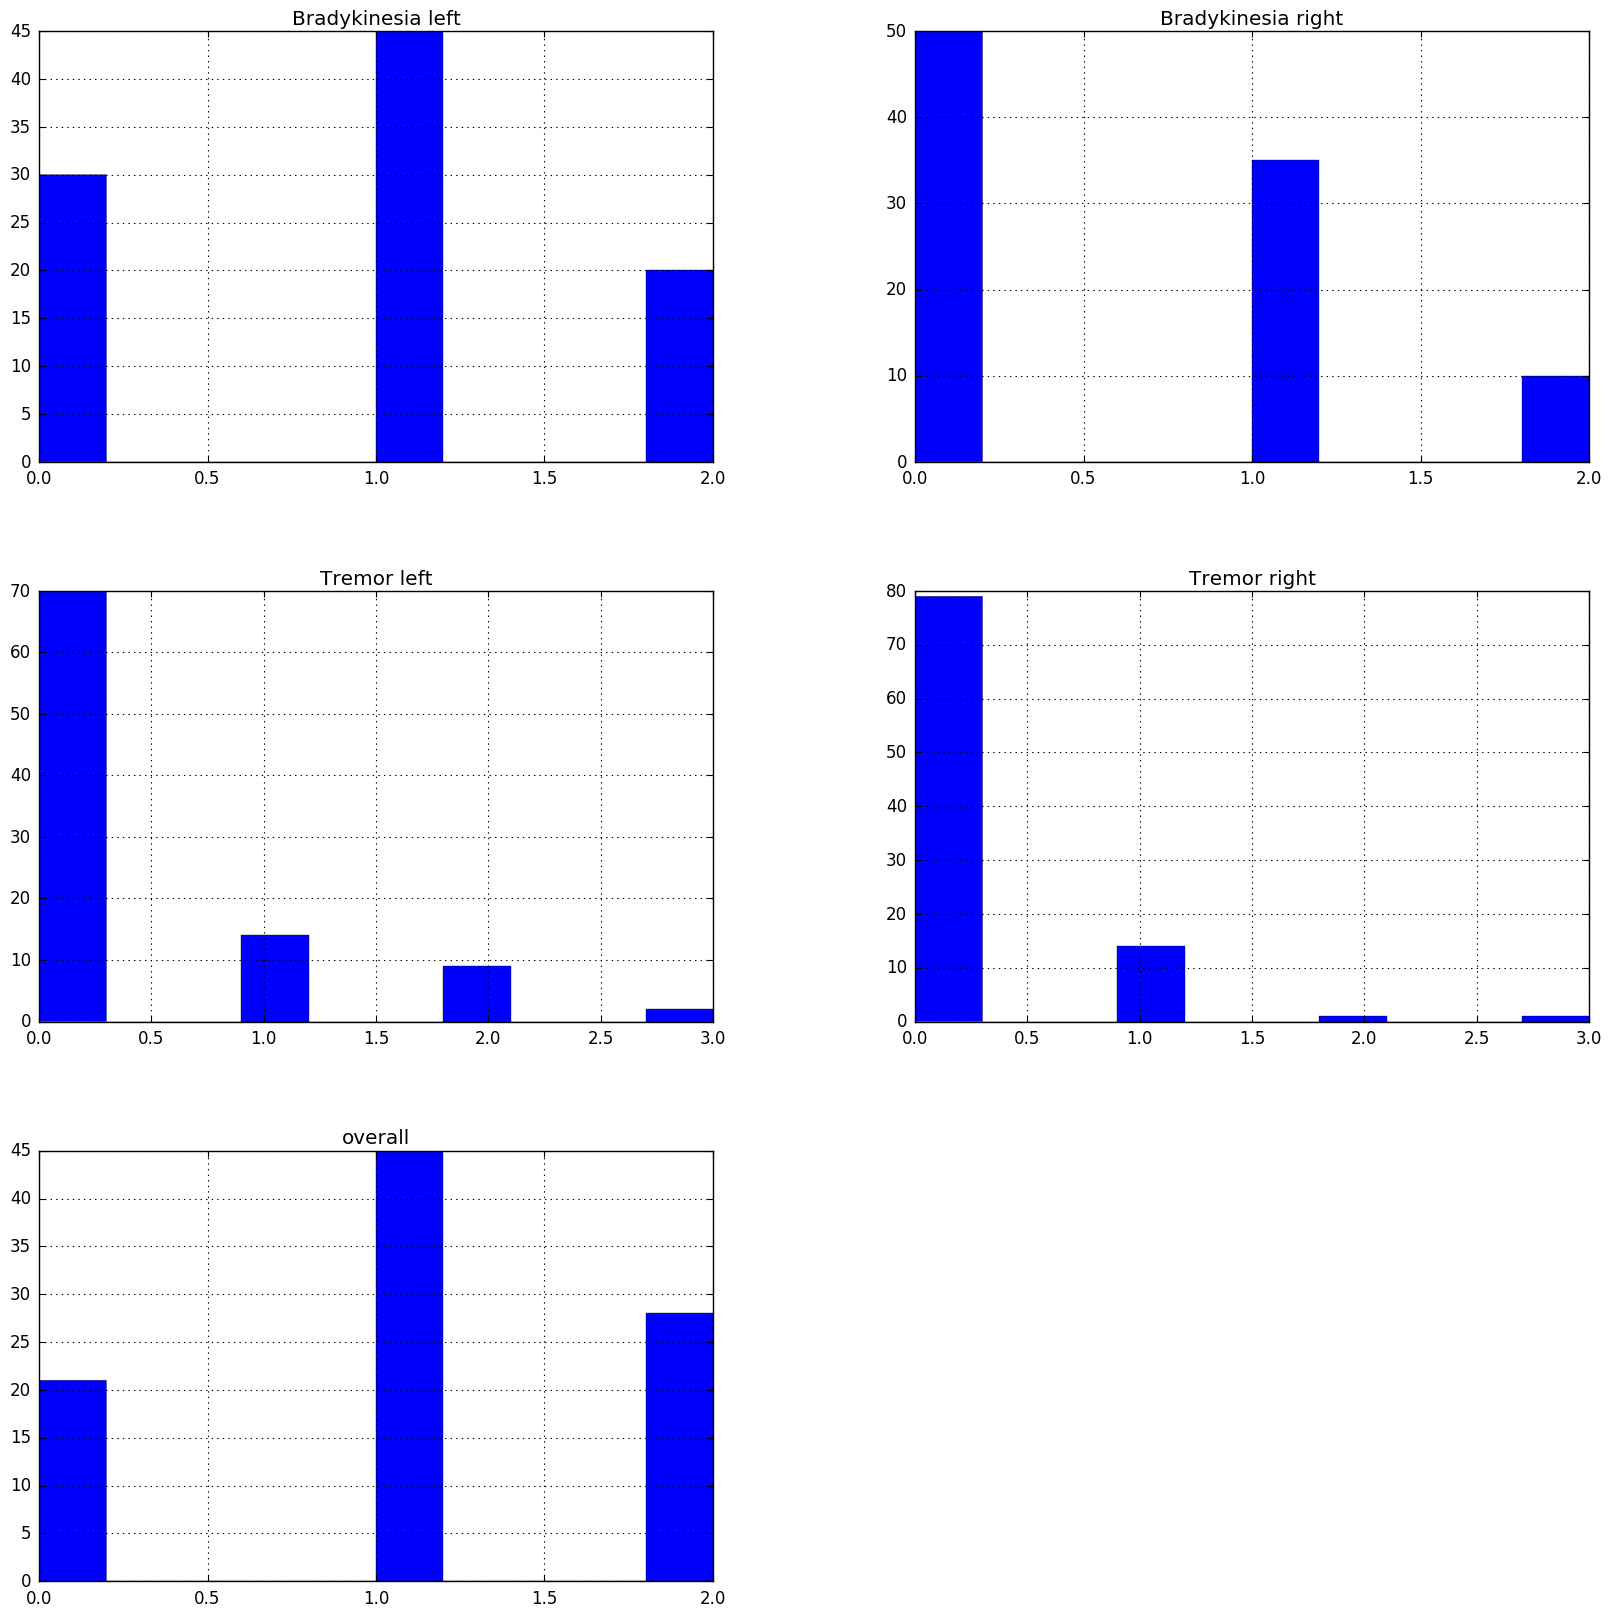

In [234]:
sns.set_context('paper',font_scale=1.5)
S.hist(figsize=(20,20),xlabelsize=12,ylabelsize=12)

# Raw sensors data visualization

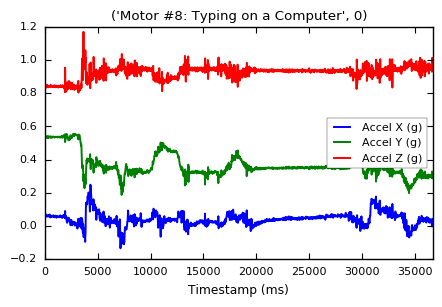

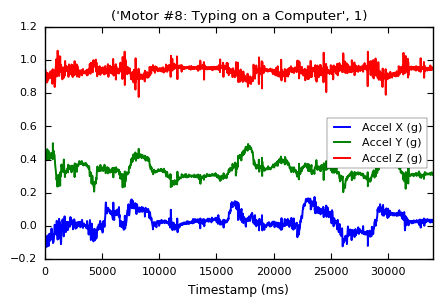

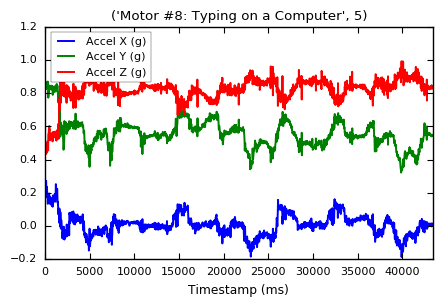

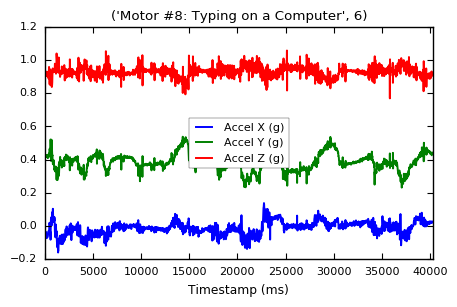

In [188]:
sns.set_context('paper')
p = product([task],trials)
taskslist = list(p)
for t in taskslist:
    plot_data(act_dict,t[0],t[1],loc,'accel')
    plt.title(t)

In [50]:
pd.DataFrame(act_dict[task][0]).loc['accel', loc]

,Accel X (g),Accel Y (g),Accel Z (g)
Timestamp (ms),,,
1499435277456,0.223819,-0.404730,0.907301
1499435277472,0.186465,-0.397528,0.926345
1499435277488,0.125795,-0.372503,0.950149
1499435277504,0.071351,-0.363226,0.950271
1499435277520,0.065980,-0.343084,0.940749
1499435277536,0.103700,-0.347112,0.923537
1499435277552,0.124331,-0.366400,0.971878
1499435277568,0.050355,-0.360784,0.998978
1499435277584,0.039246,-0.368353,1.023392
